In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from lecilab_behavior_analysis.utils import load_example_data
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
mouse = "mouse1"
df = load_example_data(mouse)

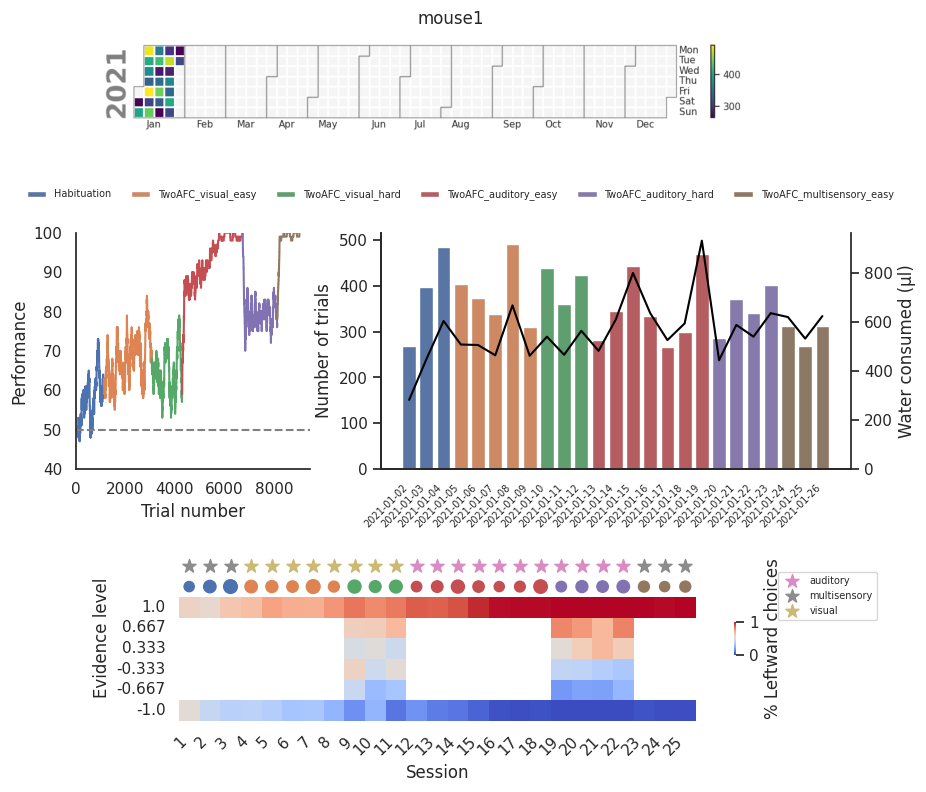

In [64]:
from lecilab_behavior_analysis.figure_maker import subject_progress_figure
fig = subject_progress_figure(df, mouse, perf_window=100)


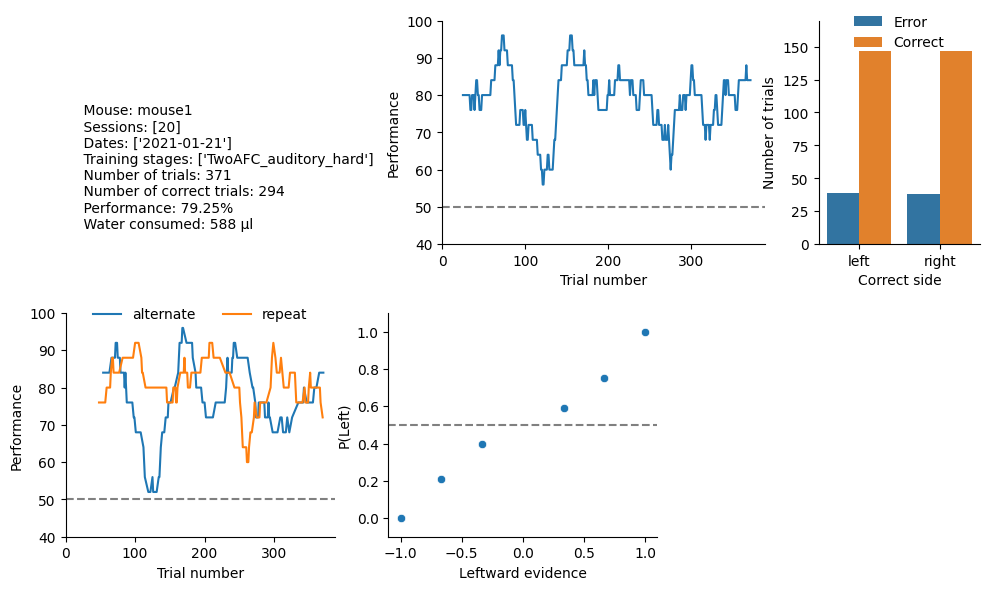

In [5]:
from lecilab_behavior_analysis.figure_maker import session_summary_figure
# select the session you want to plot
session = 20
sdf = df[df["session"] == session]
fig = session_summary_figure(sdf, mouse, perf_window=25)

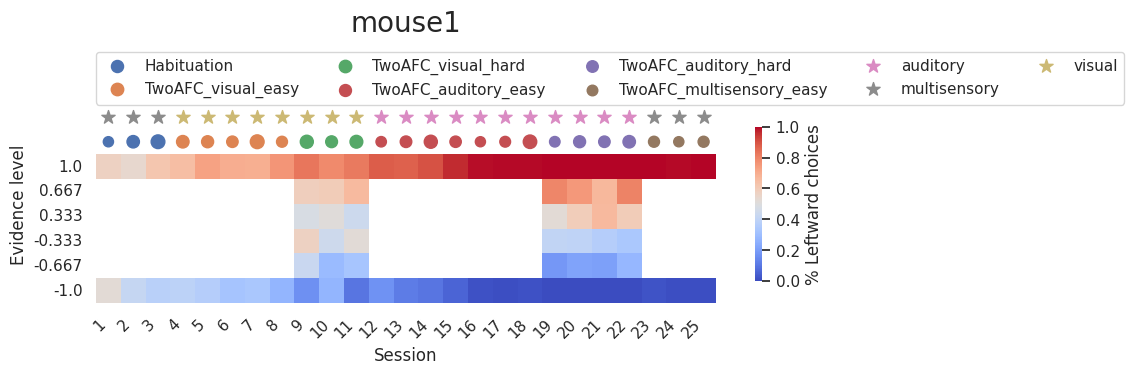

In [50]:
from lecilab_behavior_analysis.df_transforms import summary_matrix
from lecilab_behavior_analysis.plots import summary_matrix_plot

sm, dict = summary_matrix(df)
fig = plt.subplots(figsize=(10, 10))
summary_matrix_plot(sm, dict, "mouse1")
plt.show()